### Advanced Recurrent Neural Networks

The extension of $\text{RNN}$ to dynamic time series models relies on expanding the fundamental concepts of time series analysis. First, consider a smoothed $\text{RNN}$ with hidden states $\hat{h}_t$. This type of $\text{RNN}$ is nearly identical to the basic $\text{RNN}$. However, it includes an additional scalar smoothing parameter $\alpha$ that provides long memory to the network.

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

START = '1960-01-01'
TICKER = '^GSPC' # S&P500 Index

data = yf.download(
    TICKER,
    start = START,
    progress = False,
    interval = '1wk'
)

In [73]:
returns = data['Close'].pct_change(1).dropna()

In [74]:
import torch
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42) 

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

### 1. $\alpha$-RNN

Consider a univariate $\alpha$-RNN(p) model with a fixed smoothing parameter.

$$\begin{align*} 
\hat{y}_{t+1} &= W_y \hat{h}_t + b_y \\
\hat{h}_t &= \sigma(U_h \tilde{h}_{t-1} + W_h y_t + b_h) \\
\tilde{h}_t &= \alpha \hat{h}_{t-1} + (1 - \alpha) \tilde{h}_{t-1}
\end{align*}$$

The initial condition for each sequence is $\hat{h}_{t - p + 1} = y_{t-p+1}$. This model enhances the basic RNN by replacing the hidden layer's $\hat{h}_{t-1}$ with exponentially smoothed hidden states $\tilde{h}_{t-1}$. The effect of smoothing is to provide infinite memory when $\alpha \neq 1$. In this case, the RNN can be interpreted as a special case where $\alpha = 1$.

The model can be more easily interpreted by simplifying parameters and assuming no activation function. Assuming $b_y = b_h = 0$ (no y-intercept for each node) and setting $U_h = W_h = \phi, W_y = 1$, we obtain:

$$\begin{align*} 
\hat{y}_{t+1} &= \hat{h}_t \\
&= \phi(\tilde{h}_{t-1} + y_t) \\
&= \phi (\alpha \hat{h}_{t-1} + (1-\alpha) \tilde{h}_{t-2} + y_t)
\end{align*}$$

Without loss of generality, considering a time lag of $p = 2$ in the model, we have $\hat{h}_{t-1} = \phi y_{t-1}$. Then we obtain:

$$\hat{h}_t = \phi (\alpha \phi y_{t-1} + (1-\alpha)\tilde{h}_{t-2} + y_t)$$

The model can be expressed in a simpler form:

$$\hat{y}_{t+1} = \phi_1 y_t + \phi_2 y_{t-1} + \phi(1 - \alpha)\tilde{h}_{t-2}$$

Here, the autoregressive weights are $\phi_1 := \phi$ and $\phi_2 := \alpha \phi^2$. Comparing this with the AR(2) model, we can see that while the additional term vanishes when $\alpha = 1$, it provides infinite memory to the model since $\tilde{h}_{t-2}$ depends on $y_0$. Here, $y_0$ is not the first observation of the sequence but the first observation of the entire time series. The $\alpha$-RNN model can be trained by treating $\alpha$ as a hyperparameter. The choice to fix $\alpha$ is clearly limited to stationary time series. The model can be extended to non-stationary time series using a dynamic version of exponential smoothing.

In [166]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

class AlphaRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, alpha=0.5):
        super(AlphaRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.alpha = alpha 
        self.phi = nn.Parameter(torch.Tensor(hidden_size, input_size))
        
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.phi, a=0)

    def forward(self, input, hidden, smoothed_hidden):
        #h_hat = torch.sigmoid(F.linear(input, self.phi) + smoothed_hidden)
        h_hat = F.linear(input, self.phi) + smoothed_hidden
        smoothed_h = self.alpha * hidden + (1 - self.alpha) * smoothed_hidden

        return h_hat, smoothed_h
class AlphaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, alpha=0.5):
        super(AlphaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.alpha = alpha

        self.cells = nn.ModuleList(
            [AlphaRNNCell(input_size if i == 0 else hidden_size, hidden_size, alpha) for i in range(num_layers)]
        )

    def forward(self, input, hidden = None, smoothed_hidden = None):
        batch_size, seq_len, _ = input.size()

        if hidden is None:
            hidden = self.init_hidden(batch_size)
        if smoothed_hidden is None:
            smoothed_hidden = self.init_smoothed_hidden(batch_size)
        
        outputs = []
        for t in range(seq_len):
            x = input[:, t, :]  # Input at time t
            for i, cell in enumerate(self.cells):
                hidden[i], smoothed_hidden[i] = cell(x, hidden[i], smoothed_hidden[i])
                x = hidden[i] 
            outputs.append(x.unsqueeze(1))

        return torch.cat(outputs, dim=1), hidden, smoothed_hidden

    def init_hidden(self, batch_size):
        return [torch.zeros(batch_size, self.hidden_size, device=self.cells[0].phi.device) for _ in range(self.num_layers)]
    
    def init_smoothed_hidden(self, batch_size):
        return [torch.zeros(batch_size, self.hidden_size, device=self.cells[0].phi.device) for _ in range(self.num_layers)]

In [76]:
X = pd.concat(
    [returns.shift(1), returns.shift(2)], axis = 1
).dropna()
y = returns.iloc[2:].copy('deep')

X.columns = ['t-1','t-2']
y.name = 'returns'

In [77]:
X.head()

,t-1,t-2
Date,,
1960-01-22,-0.020377,-0.021612
1960-01-29,-0.018878,-0.020377
1960-02-05,0.002494,-0.018878
1960-02-12,-0.019371,0.002494
1960-02-19,0.011236,-0.019371


In [78]:
y.head()

Date
1960-01-22   -0.018878
1960-01-29    0.002494
1960-02-05   -0.019371
1960-02-12    0.011236
1960-02-19    0.002330
Name: returns, dtype: float64

In [79]:
# train test data split
X_train, X_test, y_train, y_test = X.loc[:'2019'], X.loc['2020':], y.loc[:'2019'], y.loc['2020':]

In [80]:
input_size = 2 # input size (number of features), RNN(p)
hidden_size = 2 # number of hidden nodes
output_size = 1 # output size
num_layers = 1 # number of hidden layers
learning_rate = 0.1
num_epochs = 1
batch_size = 2

# Feature Preprocessing
X_train_values = X_train.values.reshape(-1, 1, input_size)
X_test_values = X_test.values.reshape(-1, 1, input_size)

y_train_values = y_train.values.reshape(-1, 1)
y_test_values = y_test.values.reshape(-1, 1)

X_train_tensor = torch.tensor(X_train_values, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test_values, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train_values, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test_values, dtype = torch.float32)

In [81]:
import torch.optim as optim

alpha_rnn = AlphaRNN(
    input_size = input_size, 
    hidden_size = hidden_size, 
    num_layers = num_layers, 
    alpha = 0.5
)

criterion = nn.MSELoss()
optimizer = optim.Adam(
    alpha_rnn.parameters(), 
    lr = learning_rate
)

In [82]:
dataset = torch.utils.data.TensorDataset(
    X_train_tensor, 
    y_train_tensor
)
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size = batch_size, 
    shuffle = False
)

In [83]:
for epoch in range(num_epochs):
    alpha_rnn.train()
    epoch_loss = 0.0
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        
        outputs, _ ,_ = alpha_rnn(batch_X)
        outputs = torch.mean(outputs[:, -1, :], dim = 1, keepdim = True)

        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * batch_X.size(0)
    epoch_loss /= len(dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}')

Epoch [1/1], Loss: 0.000497


In [84]:
alpha_rnn.eval()
with torch.no_grad():
    predicted_alpha_rnn, _, _ = alpha_rnn(X_test_tensor)
    predicted_alpha_rnn = predicted_alpha_rnn[:, -1, :].mean(dim=1).squeeze().numpy()
    y_test_np = y_test_tensor.squeeze().numpy()

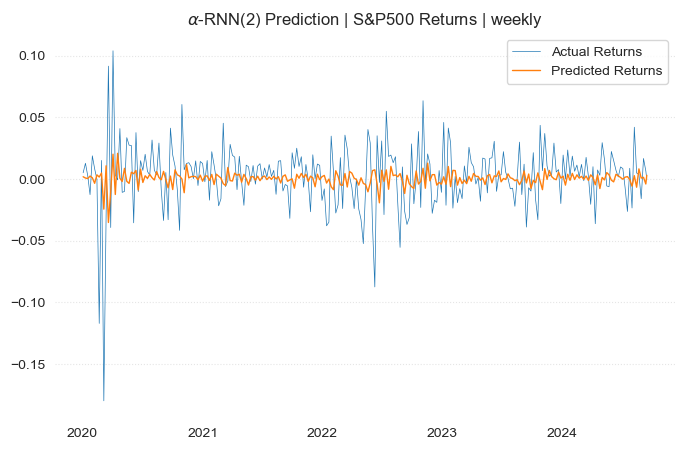

In [85]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.plot(y_test.index, y_test_np, label = 'Actual Returns', lw = 0.5)
plt.plot(y_test.index, predicted_alpha_rnn, label = 'Predicted Returns', lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title(r'$\alpha$-RNN(2) Prediction | S&P500 Returns | weekly')
plt.show()

### 2. Dynamic $\alpha_t$ RNN

Dynamic exponential smoothing is a time-dependent block combination of the smoothed output $\tilde{y}_t$ and the observed value $y_t$.

$$\tilde{y}_{t+1} = \alpha_t y_t + (1 - \alpha_t)\tilde{y}_t$$

Here, $\alpha_t \in [0,1]$ represents the time-varying smoothing coefficient, which can be equivalently expressed as a 1-step ahead forecast:

$$\tilde{y}_{t+1} = \tilde{y}_t + \alpha_t(y_t - \tilde{y}_t)$$

Therefore, the $\alpha_t \text{RNN}$ can be viewed as a generalized form of the Dynamic Forecast Error Correction Model. When $\alpha_t = 0$, the prediction error is ignored, and only smoothing is performed by repeating the current hidden state, resulting in the model losing its memory. When $\alpha_t = 1$, the prediction error completely replaces the current hidden state $\tilde{h}_t$.

Furthermore, smoothing can be viewed as a weighted sum of lagged observations $y_{t-s}$ with time lag $s \geq 1$, using weights $\alpha_{t-s} \prod_{r=1}^s (1 - \alpha_{t-r+1})$ that are equal or lower. That is:

$$\tilde{y}_{t+1} = \alpha_t y_t + \sum_{s=1}^{t-1}\alpha_{t-s} \prod_{r=1}^s (1 - \alpha_{t-r+1})y_{t-s} + \prod_{r=0}^{t-1} \tilde{y}_1$$

Here, the last term is a time-dependent constant, and typically exponential smoothing is initialized with $\tilde{y}_1 = y_1$. For any $\alpha_{t-r+1} = 1$, the prediction $\tilde{y}_{t+1}$ will have no dependence on any lags $\left\{ y_{t-s}\right\}_{s \geq r}$. The model simply forgets the $r$-th lag or observations beyond it. In the special case where smoothing is constant and equal to $1 - \alpha$, the previous expression simplifies to:

$$\tilde{y}_{t+1} = \alpha \Phi (L)^{-1}y_t$$

Or equivalently, as an $\text{AR}(1)$ Process of $\tilde{y}_{t+1}$:

$$\Phi(L) \tilde{y}_{t+1} = \alpha y_t$$

Here, the linear operator $\Phi(z) := 1 + (\alpha = 1)_z$, and $L$ is the lag operator.

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlphatRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AlphatRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.phi = nn.Parameter(torch.Tensor(hidden_size, input_size))

        self.alpha_fc = nn.Linear(input_size + hidden_size, 1) 

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.phi, a=0)
        nn.init.xavier_uniform_(self.alpha_fc.weight)

    def forward(self, input, hidden, smoothed_hidden):
        combined = torch.cat((input, hidden), dim=1)
        alpha_t = self.alpha_fc(combined)

        # Equation: h_hat_t = φ(smoothed_hidden + y_t)
        # h_hat = torch.sigmoid(F.linear(input, self.phi) + smoothed_hidden) # using activation function
        h_hat = F.linear(input, self.phi) + smoothed_hidden

        # Smoothed hidden state: α_t * h_{t-1} + (1 - α_t) * smoothed_hidden_{t-1}
        smoothed_h = alpha_t * hidden + (1 - alpha_t) * smoothed_hidden

        return h_hat, smoothed_h, alpha_t

class AlphatRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(AlphatRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.cells = nn.ModuleList([AlphatRNNCell(input_size if i == 0 else hidden_size, hidden_size) for i in range(num_layers)])

    def forward(self, input, hidden=None, smoothed_hidden=None):
        batch_size, seq_len, _ = input.size()

        if hidden is None:
            hidden = self.init_hidden(batch_size)
        if smoothed_hidden is None:
            smoothed_hidden = self.init_smoothed_hidden(batch_size)

        outputs = []
        alphas = []  # Store α_t values for each time step

        for t in range(seq_len):
            x = input[:, t, :]  # Input at time t
            for i, cell in enumerate(self.cells):
                hidden[i], smoothed_hidden[i], alpha_t = cell(x, hidden[i], smoothed_hidden[i])
                x = hidden[i]  # Hidden state from current layer used as input to next layer

            outputs.append(x.unsqueeze(1))
            alphas.append(alpha_t.unsqueeze(1))  # Store α_t for each time step

        return torch.cat(outputs, dim=1), torch.cat(alphas, dim=1), hidden, smoothed_hidden

    def init_hidden(self, batch_size):
        return [torch.zeros(batch_size, self.hidden_size, device=self.cells[0].phi.device) for _ in range(self.num_layers)]

    def init_smoothed_hidden(self, batch_size):
        return [torch.zeros(batch_size, self.hidden_size, device=self.cells[0].phi.device) for _ in range(self.num_layers)]

In [88]:
import torch.optim as optim

alpha_t_rnn = AlphatRNN(
    input_size = input_size, 
    hidden_size = hidden_size, 
    num_layers = num_layers
)

criterion = nn.MSELoss()
optimizer = optim.Adam(
    alpha_t_rnn.parameters(), 
    lr = learning_rate
)

In [89]:
num_epochs = 1
for epoch in range(num_epochs):
    alpha_t_rnn.train()
    optimizer.zero_grad()

    outputs, alphas, hidden, smoothed_hidden = alpha_t_rnn(X_train_tensor)

    outputs = torch.mean(outputs[:, -1, :], dim = 1, keepdim = True)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/1], Loss: 0.000948


In [90]:
alpha_t_rnn.eval()
with torch.no_grad():
    predicted_alpha_t_rnn, alphas, _, _ = alpha_t_rnn(X_test_tensor)
    predicted_alpha_t_rnn = predicted_alpha_t_rnn[:, -1, :].mean(dim=1).squeeze().numpy()
    y_test_np = y_test_tensor.squeeze().numpy()

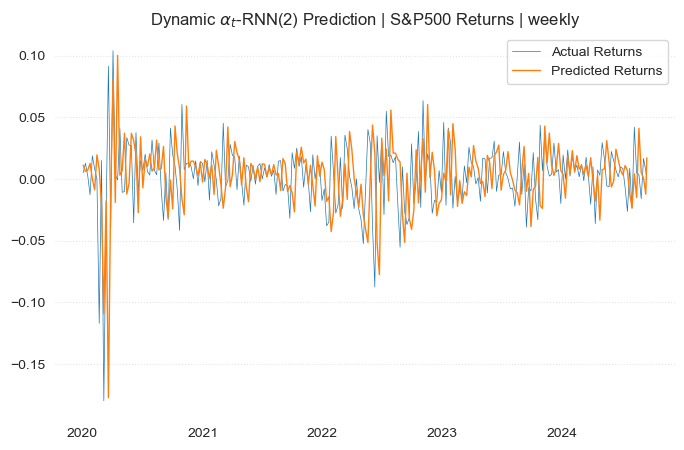

In [91]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.plot(y_test.index, y_test_np, label = 'Actual Returns', lw = 0.5)
plt.plot(y_test.index, predicted_alpha_t_rnn, label = 'Predicted Returns', lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title(r'Dynamic $\alpha_t$-RNN(2) Prediction | S&P500 Returns | weekly')
plt.show()

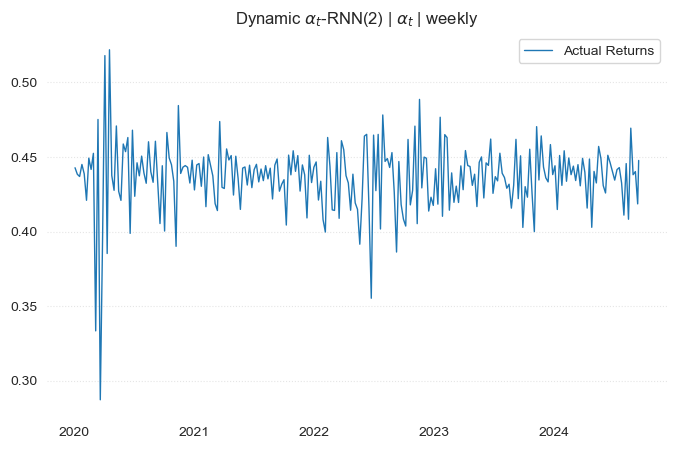

In [92]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.plot(
    y_test.index,
    alphas[:, -1, :].mean(dim=1).squeeze().numpy(), 
    label = 'Actual Returns', 
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title(r'Dynamic $\alpha_t$-RNN(2) | $\alpha_t$ | weekly')
plt.show()

### 3. Gated Recurrent Unit

Instead of smoothing the observed time series $\left\{ y_s\right\}_{s \leq 1}$, let's assume we smooth the hidden vector $\hat{h}_t$ with $\hat{\alpha}_t \in [0, 1]^H$ to obtain the following filtered time series:

$$\tilde{h}_t = \hat{\alpha}_t \circ \hat{h}_t + (1 - \hat{\alpha}_t) \circ \tilde{h}_{t-1}$$

Here $\circ$ denotes the Hadamard product between vectors. The smoothing is a vectorized form of the classical setting. Note that when $(\alpha_t)_i = 1$, the $i$-th component of the hidden vector remains unchanged and the past filtered hidden vector is forgotten. On the other hand, when $(\alpha_t)_i = 0$, the $i$-th component of the hidden vector disappears and instead the current filtered hidden vector is set to the past value. This smoothing can be viewed as updating long-term memory and maintaining smoothed hidden state variables through a convex combination of current hidden variables and past smoothed hidden variables. The hidden variable is given by a quasi-affine transformation:

$$\hat{h}_t = \sigma(U_h \tilde{h}_{t-1} + W_hx_t + b_h)$$

This time, the hidden variable depends on the previous smoothed hidden variable. Using the above two equations, we can obtain:

$$\tilde{h}_t = g(\tilde{h}_{t-1}, x_t ; \alpha) := \hat{\alpha}_t \circ \sigma(U_h \tilde{h}_{t-1} + W_h x_t + b_h) + (1 - \hat{\alpha}_t) \circ \tilde{h}_{t-1}$$

When $\alpha_t = 0$, the smoothed hidden variable $\tilde{h}_t$ is not updated by the input $x_t$. Conversely, when $\alpha_t = 1$, the hidden variable behaves like a locally nonlinear autoregressive time series. Therefore, the smoothing parameter can be viewed as the sensitivity of the smoothed state to the input $x_t$.

The problem becomes how to dynamically determine how much error correction is needed. The GRU solves this problem by using a basic RNN parameterized by weights and biases $(W_\alpha, U_\alpha, b_\alpha)$ to learn $\hat{\alpha} = F_{(W_\alpha, U_\alpha, b_\alpha)}(X)$ from input variables. The 1-step forward prediction of smoothed hidden states $\tilde{h}_t$ is the filtered output of another basic RNN with weights and biases $(W_\alpha, U_\alpha, b_\alpha)$. Combining everything, we obtain the following $\alpha_t$ model (a simple GRU network):

$$\begin{align*} 
\tilde{h}_t &= \hat{\alpha}_t \circ \hat{h}_t + (1 - \hat{\alpha}_t) \circ \tilde{h}_{t-1} \\
\hat{\alpha}_t &= \sigma^{(1)}(U_{\alpha}\tilde{h}_{t-1} + W_{\alpha}x_t + b_{\alpha}) \\
\hat{h}_{t} &= \sigma(U_h \tilde{h}_{t-1} + W_h x_t + b_h)
\end{align*}$$

Here $\sigma^{(1)}$ is a sigmoid or Heaviside function, and $\sigma$ is an arbitrary activation function. In the above $\alpha_t$-RNN, there is no way to directly forget memory sometimes. This is because unless $U_h = 0$, the variable update equation always depends on the previous smoothed state. However, the fitted recurrent weight $\hat{U}_h$ is generally not zero, so the model does not have a complete reset button. The GRU also has the ability to completely reset memory by adding an additional reset variable.

$$\begin{align*}
\tilde{h}_t &= \hat{\alpha}_t \circ \hat{h}_t + (1 - \hat{\alpha}_t) \circ \tilde{h}_{t-1} \\
\hat{\alpha}_t &= \sigma^{(1)}(U_\alpha \hat{h}_{t-1} + W_\alpha x_t + b_\alpha) \\
\hat{h}_t &= \sigma(U_h \hat{r}_t \circ \tilde{h}_{t-1} + W_h x_t + b_h) \\
\hat{r}_t &= \sigma^{(1)}(U_r \tilde{h}_{t-1} + W_r x_t + b_r)
\end{align*}$$

The effect of introducing the reset or switch $\hat{r}_t$ is to forget the dependence on the smoothed hidden states of $\hat{h}_t$. Effectively, it transforms the update of $\hat{h_t}$ from a basic RNN to an FFNN, allowing complete forgetting of recurrence. Therefore, recurrence in the update of $\hat{h}_t$ is dynamic. The combination of reset and adaptive smoothing may seem redundant, but while $\hat{r}_t$ adjusts the recurrence level of the unsmoothed hidden states $\hat{h}_t$, $\hat{\alpha}_t$ affects the recurrence level of the smoothed hidden states $\tilde{h}_t$. In other words, $\hat{\alpha}_t$ itself cannot remove the memory of smoothed hidden states, but $\hat{r}_t$ combined with $\hat{\alpha}_t$ can. More precisely, when $\alpha_t = 1$ and $\hat{r}_t = 0$, $\tilde{h}_t = \hat{h}_t = \sigma(W_h x_t + b_h)$, which is reset to the last input $x_t$ and the GRU becomes just an FFNN. When $\alpha_t = 1$ and $\hat{r}_t > 0$, the GRU operates like a basic RNN. Therefore, the GRU can be viewed as a general structure that can become either just an FFNN or a basic RNN at specific parameter values.

These additional accounts allow the GRU to learn extremely complex long-term time series dynamics that basic RNNs cannot learn. The price to pay for this flexibility is additional model complexity. Clearly, one must choose whether to use a simpler model like the $\alpha_t$-RNN or the GRU. Finally, it is briefly mentioned that, as in RNNs, GRUs also have a final feedforward layer that transforms hidden states into responses.

$$\hat{y}_t = W_Y \tilde{h}_t + b_Y$$

In [93]:
class GatedRecurrentUnitCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GatedRecurrentUnitCell, self).__init__()
        self.hidden_size = hidden_size
        
        self.W_alpha = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.U_alpha = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_alpha = nn.Parameter(torch.Tensor(hidden_size))
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.U_h = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.Tensor(hidden_size))
        
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.W_alpha, a=np.sqrt(5))
        nn.init.kaiming_uniform_(self.U_alpha, a=np.sqrt(5))
        nn.init.kaiming_uniform_(self.W_h, a=np.sqrt(5))
        nn.init.kaiming_uniform_(self.U_h, a=np.sqrt(5))
        nn.init.zeros_(self.b_alpha)
        nn.init.zeros_(self.b_h)

    def forward(self, x, h_prev, h_smooth_prev):
        alpha_t = torch.matmul(x, self.W_alpha.t()) + torch.matmul(h_smooth_prev, self.U_alpha.t()) + self.b_alpha


        h_hat_t = torch.matmul(x, self.W_h.t()) + torch.matmul(h_smooth_prev, self.U_h.t()) + self.b_h

        h_smooth_t = alpha_t * h_hat_t + (1 - alpha_t) * h_smooth_prev
        
        return h_smooth_t, h_hat_t

class GatedRecurrentUnit(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GatedRecurrentUnit, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.layers = nn.ModuleList(
            [GatedRecurrentUnitCell(input_size if i == 0 else hidden_size, hidden_size) for i in range(num_layers)]
        )

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h_prev = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        h_smooth_prev = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        
        for t in range(seq_len):
            x_t = x[:, t, :]
            
            for i in range(self.num_layers):
                h_smooth_prev[i], h_prev[i] = self.layers[i](x_t, h_prev[i], h_smooth_prev[i])
                x_t = h_smooth_prev[i] 
                
        output = self.fc(h_smooth_prev[-1])
        
        return output

In [124]:
input_size = 2 # input size (number of features), GRU(p)
hidden_size = 10 # number of hidden nodes
output_size = 1 # output size
num_layers = 1 # number of hidden layers
learning_rate = 0.1
num_epochs = 1
batch_size = 1

In [125]:
gru = GatedRecurrentUnit(
    input_size, 
    hidden_size,
    output_size, 
    num_layers
)
criterion = nn.MSELoss()
optimizer = optim.Adam(
    gru.parameters(), 
    lr = learning_rate
)

In [126]:
for epoch in range(num_epochs):
    gru.train()
    optimizer.zero_grad()

    outputs = gru(X_train_tensor)

    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/1], Loss: 0.007553


In [127]:
gru.eval()
with torch.no_grad():
    predicted_gru = gru(X_test_tensor).squeeze().numpy()
    y_test_np = y_test_tensor.squeeze().numpy()

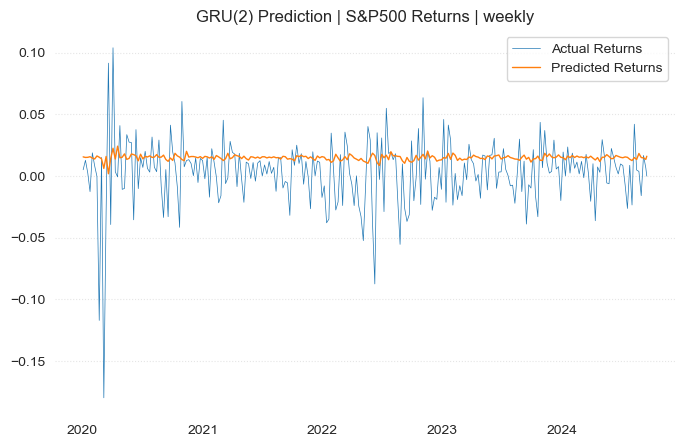

In [128]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.plot(y_test.index, y_test_np, label = 'Actual Returns', lw = 0.5)
plt.plot(y_test.index, predicted_gru, label = 'Predicted Returns', lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title(r'GRU(2) Prediction | S&P500 Returns | weekly')
plt.show()

### 4. LSTM

$\text{GRU}$ provides a gating mechanism for propagating smoothed hidden states, which can be redefined to make $\text{GRU}$ into a basic $\text{RNN}$ or even a memory-less Feed Forward Neural Network. More complex models using hidden units with various connections within memory units have been proposed in engineering literature with empirical success. $\text{LSTM}$ is similar to $\text{GRU}$ but has a separate cell memory $C_t$ in addition to the hidden state. Also, $\text{LSTM}$ does not require memory updates to be block combinations, making it more general than exponential smoothing. While mathematical explanations of $\text{LSTM}$ are rarely provided in intuitive forms, the model can be found in works such as Hochreiter and Schmidhuber.

Cell memory is updated by the following expression associated with the forget gate $\hat{\alpha}_t$, input gate $\hat{z}_t$, and cell gate $\hat{c}_t$:

$$c_t = \hat{\alpha}_t \circ c_{t-1} + \hat{z}_t \circ \hat{c}_t$$

In $\text{LSTM}$ terminology, $\hat{\alpha}_t, \hat{r}_t, \hat{z}_t$ are called forget gate, output gate, and input gate respectively. In the special case where $\hat{z}_t = 1 - \hat{\alpha}_t$, we obtain a similar exponential smoothing expression as used in $\text{GRU}$. Beyond this, the role of the input gate seems unnecessary and difficult to justify through time series analysis. Similarly, this appears to come purely from the context of engineering models. However, it's worth exploring how additional variables provide $\text{LSTM}$ with more complex and sophisticated temporal dynamics.

When the forget gate $\hat{\alpha}_t = 0$, cell memory depends only on the cell memory date update $\hat{c}_t$. Due to the $\hat{\alpha}_t \circ c_{t-1}$ term, cell memory is long memory that only forgets beyond lag $s$ when $\hat{\alpha}_{t-s} = 0$. The additional memory treated as hidden state and separated from cell memory is simply a Hadamard product:

$$\hat{h}_t = \hat{r}_t \circ \tanh(c)_t$$

Here, if $\hat{r}_t = 0$, it is reset. If $\hat{r}_t = 1$, cell memory directly determines the hidden state. Thus, the reset gate resets without completely erasing the autoregressive structure effect of cell memory. In contrast, $\text{GRU}$ has one memory that serves as hidden state, which is directly affected by the reset gate. The reset, forget, input, and cell memory gates are updated by the basic $\text{RNN}$ and all depend on the hidden state $h_t$.

$$\begin{align*}
\hat{r}_t &= \sigma(U_r h_{t-1} + W_r x_t + b_r) \\ 
\hat{\alpha}_t &= \sigma(U_\alpha h_{t-1} + W_\alpha x_t + b_\alpha) \\
\hat{z}_t &= \sigma(U_z h_{t-1} + W_z x_t + b_z) \\
\hat{c}_t &= \tanh(U_c h_{t-1} + W_c x_t + b_c)
\end{align*}$$

Like $\text{GRU}$, $\text{LSTM}$ can also operate as a simple $\text{RNN}$. Just set $\alpha_t = 0$ in the above equations. However, $\text{LSTM}$ can also operate as a combination of $\text{FFN}$. Simply setting $\hat{r}_t$ makes $h_t = 0$, so there is no recurrent structure in the gates. Despite what the nomenclature might suggest, both $\text{GRU}$ and $\text{LSTM}$ can model long-term and short-term autoregressive memory. $\text{GRU}$ combines these values through smoothed hidden state variables. $\text{LSTM}$ separates long-term memory stored in cell memory but additionally uses a copy that can be reset. Strictly speaking, since cell memory has a short-long term autoregressive memory structure, strictly distinguishing between the two memories is potentially misleading in the context of time series analysis. The latter can be thought of as a truncated version of the former.

In [129]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers = 1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])
        return out

In [130]:
input_size = 2 # input size (number of features), RNN(p)
hidden_size = 2 # number of hidden nodes
output_size = 1 # output size
num_layers = 1 # number of hidden layers
learning_rate = 0.1
num_epochs = 1

In [131]:
lstm = LSTM(
    input_size, 
    hidden_size, 
    output_size, 
    num_layers
)
criterion = nn.MSELoss()
optimizer = optim.Adam(
    lstm.parameters(), 
    lr = learning_rate
)

In [132]:
for epoch in range(num_epochs):
    lstm.train()
    optimizer.zero_grad()

    outputs = lstm(X_train_tensor)

    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/1], Loss: 0.447999


In [133]:
lstm.eval()
with torch.no_grad():
    predicted_lstm = lstm(X_test_tensor).squeeze().numpy()
    y_test_np = y_test_tensor.squeeze().numpy()

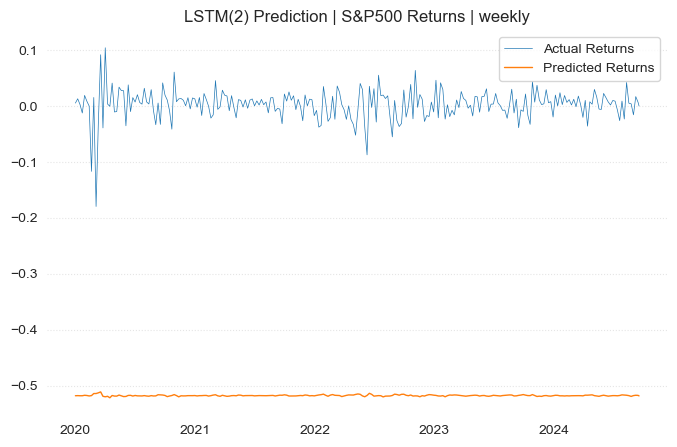

In [134]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.plot(y_test.index, y_test_np, label = 'Actual Returns', lw = 0.5)
plt.plot(y_test.index, predicted_lstm, label = 'Predicted Returns', lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title(r'LSTM(2) Prediction | S&P500 Returns | weekly')
plt.show()

### Model Comparison

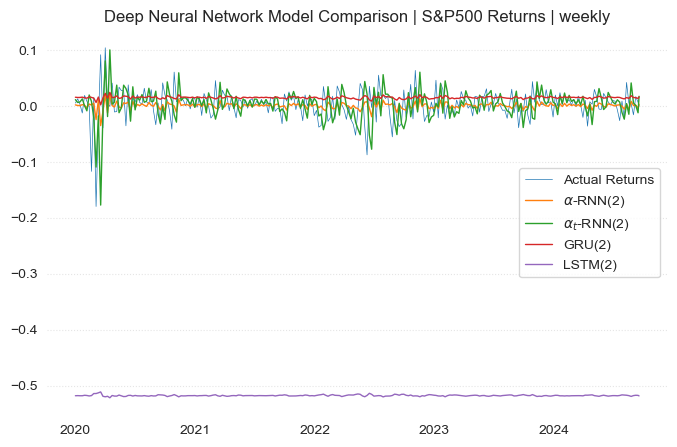

In [135]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.plot(y_test.index, y_test_np, label = 'Actual Returns', lw = 0.5)
plt.plot(y_test.index, predicted_alpha_rnn, label = r'$\alpha$-RNN(2)', lw = 1)
plt.plot(y_test.index, predicted_alpha_t_rnn, label = r'$\alpha_t$-RNN(2)', lw = 1)
plt.plot(y_test.index, predicted_gru, label = 'GRU(2)', lw = 1)
plt.plot(y_test.index, predicted_lstm, label = 'LSTM(2)', lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title(r'Deep Neural Network Model Comparison | S&P500 Returns | weekly')
plt.show()

### Using Fractional Differentiation Data

앞서 소개한 실수 차분 모형($\text{ARFIMA}$)는 Augmented Dickey Fuller의 시계열 정상성을 지키면서도 Long Memory를 최대한 보존시키는 모형이라고 언급한 바 있다. 이번 절에서는 추가적으로 $\text{ARFIMA}$로부터 Recurrent Neural Network를 이용해 예측력을 올려보고자 한다. 이미 $\alpha - \text{RNN}$에서 activation function은 선형 함수로 처리했으므로, 별다른 정규화 과정 없이 예측 모형을 구축할 수 있다.

In [150]:
from quant_free.finml.features.fracdiff import FractionalDifferentiatedFeatures

frac_close = FractionalDifferentiatedFeatures.fracDiff(data[['Close']], 0.5)

In [151]:
X = pd.concat(
    [frac_close.shift(i) for i in range(1, 16)], axis = 1
).dropna()
y = frac_close.iloc[15:].copy('deep')

X.columns = [f't-{i}' for i in range(1, 16)]
y.name = 'returns'

In [152]:
X.head()

,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12,t-13,t-14,t-15
1967-04-07,3.598438,4.528460,5.500196,5.592440,4.391086,4.472525,3.778669,4.683286,4.762444,4.817340,4.299982,5.595249,4.932982,3.102549,1.255872
1967-04-14,3.343976,3.598438,4.528460,5.500196,5.592440,4.391086,4.472525,3.778669,4.683286,4.762444,4.817340,4.299982,5.595249,4.932982,3.102549
1967-04-21,6.208756,3.343976,3.598438,4.528460,5.500196,5.592440,4.391086,4.472525,3.778669,4.683286,4.762444,4.817340,4.299982,5.595249,4.932982
1967-04-28,6.594188,6.208756,3.343976,3.598438,4.528460,5.500196,5.592440,4.391086,4.472525,3.778669,4.683286,4.762444,4.817340,4.299982,5.595249
1967-05-05,5.901710,6.594188,6.208756,3.343976,3.598438,4.528460,5.500196,5.592440,4.391086,4.472525,3.778669,4.683286,4.762444,4.817340,4.299982


In [153]:
y.head()

,Close
1967-04-07,3.343976
1967-04-14,6.208756
1967-04-21,6.594188
1967-04-28,5.901710
1967-05-05,4.669009


In [154]:
# train test data split
X_train, X_test, y_train, y_test = X.loc[:'2019'], X.loc['2020':], y.loc[:'2019'], y.loc['2020':]

In [167]:
input_size = 15 # input size (number of features), RNN(p)
hidden_size = 5 # number of hidden nodes
output_size = 1 # output size
num_layers = 1 # number of hidden layers
learning_rate = 0.001
num_epochs = 1
batch_size = 2

# Feature Preprocessing
X_train_values = X_train.values.reshape(-1, 1, input_size)
X_test_values = X_test.values.reshape(-1, 1, input_size)

y_train_values = y_train.values.reshape(-1, 1)
y_test_values = y_test.values.reshape(-1, 1)

X_train_tensor = torch.tensor(X_train_values, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test_values, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train_values, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test_values, dtype = torch.float32)

In [168]:
dataset = torch.utils.data.TensorDataset(
    X_train_tensor,
    y_train_tensor
)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False
)

In [169]:
alpha_rnn_fd = AlphaRNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    alpha=0.5
)

criterion = nn.MSELoss()
optimizer = optim.Adam(
    alpha_rnn_fd.parameters(),
    lr=learning_rate
)

In [170]:
for epoch in range(num_epochs):
    alpha_rnn_fd.train()
    epoch_loss = 0.0
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()

        outputs, _ ,_ = alpha_rnn_fd(batch_X)
        outputs = torch.mean(outputs[:, -1, :], dim = 1, keepdim = True)

        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_X.size(0)
    epoch_loss /= len(dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}')

Epoch [1/1], Loss: 520.549842


In [171]:
alpha_rnn_fd.eval()
with torch.no_grad():
    predicted_alpha_rnn_fd, alphas, _= alpha_rnn_fd(X_test_tensor)
    predicted_alpha_rnn_fd = predicted_alpha_rnn_fd[:, -1, :].mean(dim=1).squeeze().numpy()
    y_test_np = y_test_tensor.squeeze().numpy()

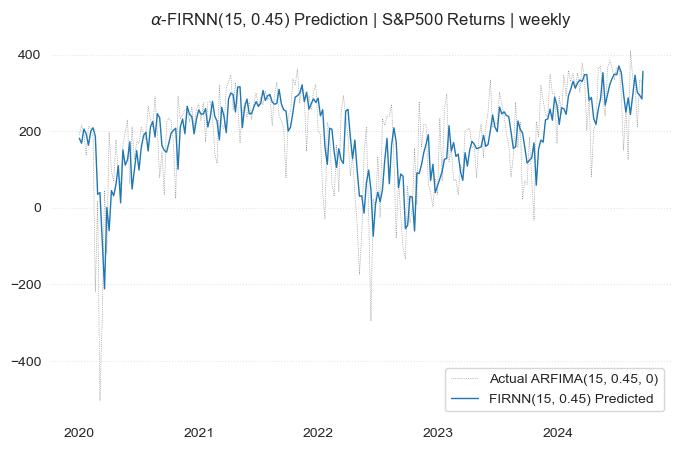

In [179]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(y_test.index, y_test_np, label='Actual ARFIMA(15, 0.45, 0)', lw=0.5, color = 'gray', ls = ':')
plt.plot(y_test.index, predicted_alpha_rnn_fd, label='FIRNN(15, 0.45) Predicted', lw=1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls=':', alpha=0.5)
plt.legend()
plt.title(r'$\alpha$-FIRNN(15, 0.45) Prediction | S&P500 Returns | weekly')
plt.show()

동일하게 hidden states에 대해서 동적 평활화 factor를 가진 $\alpha_t - \text{RNN}$에 대해서도 $\text{ARFIMA}$ 모형을 이용해 long-memory model을 구축할 수 있다. 이를 $\alpha_t -\text{FIRNN}$이라 하자.

In [173]:
alpha_t_rnn_fd = AlphaRNN(
    input_size = input_size,
    hidden_size = hidden_size,
    num_layers = num_layers
)

criterion = nn.MSELoss()
optimizer = optim.Adam(
    alpha_t_rnn_fd.parameters(),
    lr=learning_rate
)

In [174]:
for epoch in range(num_epochs):
    alpha_t_rnn_fd.train()
    epoch_loss = 0.0
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()

        outputs, _ ,_ = alpha_t_rnn_fd(batch_X)
        outputs = torch.mean(outputs[:, -1, :], dim = 1, keepdim = True)

        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_X.size(0)
    epoch_loss /= len(dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}')

Epoch [1/1], Loss: 524.647204


In [175]:
alpha_t_rnn_fd.eval()
with torch.no_grad():
    predicted_alpha_t_rnn_fd, alphas, _= alpha_t_rnn_fd(X_test_tensor)
    predicted_alpha_t_rnn_fd = predicted_alpha_t_rnn_fd[:, -1, :].mean(dim=1).squeeze().numpy()
    y_test_np = y_test_tensor.squeeze().numpy()

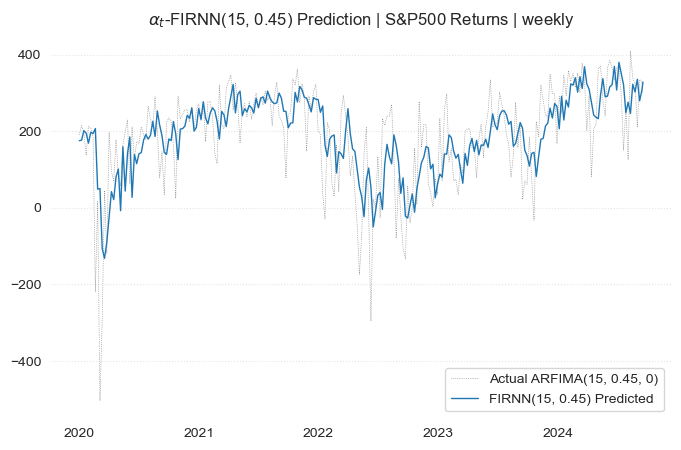

In [178]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(y_test.index, y_test_np, label='Actual ARFIMA(15, 0.45, 0)', lw = 0.5, color = 'gray', ls = ':')
plt.plot(y_test.index, predicted_alpha_t_rnn_fd, label='FIRNN(15, 0.45) Predicted', lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls=':', alpha=0.5)
plt.legend()
plt.title(r'$\alpha_t$-FIRNN(15, 0.45) Prediction | S&P500 Returns | weekly')
plt.show()